In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib.colors as mcolors
import seaborn as sns


# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import shapiro

import warnings

### Yale Climate Opinion Map Data

In [2]:
df_14 = pd.read_csv("YCOMD\YPCCC_County_n28_2015Jan5.txt", sep=",", encoding="cp1252")
df_16 = pd.read_csv("YCOMD\YCOM_2016_Data.01.txt", sep=",")
df_18 = pd.read_csv("YCOMD\YCOM_2018_Data.txt", sep=",", encoding="cp1252")
df_21 = pd.read_csv("YCOMD\YCOM6.0_2021_Data_.csv", encoding="cp1252")#, sep=",")

In [3]:
#filter by GeoType County for 16,18,21
df_16 = df_16[df_16['GeoType'] == 'County'] 
df_18 = df_18[df_18['GeoType'] == 'County'] 
df_21 = df_21[df_21['GeoType'] == 'County'] 

In [4]:
df_16['GEOID']

52       1001
53       1003
54       1005
55       1007
56       1009
        ...  
3189    56037
3190    56039
3191    56041
3192    56043
3193    56045
Name: GEOID, Length: 3142, dtype: int64

In [5]:
##2016 and 2021

In [6]:
list(set(df_16['GeoName'])-set(df_21['GeoName']))

['Do_a Ana County, New Mexico', 'Wade Hampton Census Area, Alaska']

In [7]:
list(set(df_16['GEOID'])-set(df_21['GEOID']))

[46113, 2270]

In [8]:
list(set(df_21['GeoName'])-set(df_16['GeoName']))

['Kusilvak Census Area, Alaska', 'Doña Ana County, New Mexico']

In [9]:
list(set(df_21['GEOID'])-set(df_16['GEOID']))

[2158, 46102]

In [10]:
## 2016 and 2018

In [11]:
list(set(df_16['GeoName'])-set(df_18['GeoName']))

['Do_a Ana County, New Mexico', 'Wade Hampton Census Area, Alaska']

In [12]:
list(set(df_18['GeoName'])-set(df_16['GeoName']))

['Kusilvak Census Area, Alaska', 'Doña Ana County, New Mexico']

In [13]:
## 2018 and 2021

In [14]:
list(set(df_18['GeoName'])-set(df_21['GeoName']))

[]

In [15]:
list(set(df_21['GeoName'])-set(df_18['GeoName']))

[]

#### notes
1. Kusilvak Census Area, Alaska (2018, 2021) was formerly known as Wade Hampton Census Area, Alaska (2016)
2. Do_a Ana County, New Mexico (2016) == Doña Ana County, New Mexico (2018, 2021)

In [16]:
#add year column to all
ydfs = [df_14,df_16,df_18,df_21]
year = ['2014', '2016', '2018', '2021']

for df,y in zip(ydfs,year):
    df['year'] = y

#df 14 has different names for county name and codes
cols = ['year','Countyname','Countycode','happening','harmUS','timing','personal','futuregen','worried','human','fundrenewables','regulate','CO2limits']

merged_ycom1 = df_14[cols]


#subset for 16,18,21 (difference in county col namings)
df_18['GEOID'] = df_21['GEOID'] #becuse 2018 didn't have GEOID col no difference between 2018 and 2021 count names

#renaming counties in 2016 so that same as names in 2018 and 2021
df_16['GeoName'] = df_16['GeoName'].replace({'Do_a Ana County, New Mexico': 'Doña Ana County, New Mexico', 'Wade Hampton Census Area, Alaska': 'Kusilvak Census Area, Alaska'})

ydfs = [df_16,df_18,df_21]
cols = ['year','GeoName','GEOID','happening','harmUS','timing','personal','futuregen','worried','human','fundrenewables','regulate','CO2limits']
appended_data = []
for df in ydfs:
    subset = df[cols]
    appended_data.append(subset)
    
merged_ycom2 = pd.concat(appended_data)

####merge the 
merged_ycom2.rename(columns = {'GeoName':'Countyname'}, inplace = True)
merged_ycom2.rename(columns = {'GEOID':'Countycode'}, inplace = True)
all_ycom = pd.concat([merged_ycom1, merged_ycom2], ignore_index=True, axis=0)
all_ycom

year                  Countyname  Countycode  happening  harmUS  \
0      2014     Autauga County, Alabama        1001     55.000  45.000   
1      2014     Baldwin County, Alabama        1003     57.000  45.000   
2      2014     Barbour County, Alabama        1005     57.000  46.000   
3      2014        Bibb County, Alabama        1007     52.000  42.000   
4      2014      Blount County, Alabama        1009     57.000  47.000   
...     ...                         ...         ...        ...     ...   
12564  2021  Sweetwater County, Wyoming       56037     54.607  55.404   
12565  2021       Teton County, Wyoming       56039     78.141  68.510   
12566  2021       Uinta County, Wyoming       56041     61.577  55.591   
12567  2021    Washakie County, Wyoming       56043     49.461  52.342   
12568  2021      Weston County, Wyoming       56045     57.819  53.953   

       timing  personal  futuregen  worried   human  fundrenewables  regulate  \
0      38.000    30.000     54.000   45.000  43.000          73.000    70.000   
1      37.000    30.000     56.000   47.000  43.000          74.000    71.000   
2      41.000    33.000     53.000   46.000  43.000          71.000    69.000   
3      36.000    29.000     50.000   41.000  39.000          70.000    66.000   
4      40.000    31.000     56.000   49.000  48.000          75.000    72.000   
...       ...       ...        ...      ...     ...             ...       ...   
12564  47.807    38.282     59.835   53.655  43.250          67.052    61.836   
12565  63.604    48.920     72.720   69.929  60.462          82.728    73.956   
12566  49.658    38.670     59.768   53.195  46.104          69.822    62.948   
12567  44.723    35.808     58.991   50.383  40.735          64.264    59.534   
12568  47.094    36.642     57.199   49.486  42.625          68.541    60.327   

       CO2limits  
0         54.000  
1         55.000  
2         54.000  
3         50.000  
4         59.000  
...          ...  
12564     43.642  
12565     72.668  
12566     52.227  
12567     39.454  
12568     47.595  

[12569 rows x 13 columns]

In [17]:
all_ycom.year.unique()

array(['2014', '2016', '2018', '2021'], dtype=object)

In [18]:
ydfs = [df_14,df_16,df_18,df_21]
for i in ydfs:
    print(i.shape)

(3143, 62)
(3142, 39)
(3142, 61)
(3142, 65)


In [19]:
print(all_ycom.shape)

(12569, 13)


In [20]:
all_ycom['Countycode'] = all_ycom['Countycode'].astype(float)
all_ycom['year'] = all_ycom['year'].astype(str).astype(int)

In [21]:
all_ycom.dtypes

year                int32
Countyname         object
Countycode        float64
happening         float64
harmUS            float64
timing            float64
personal          float64
futuregen         float64
worried           float64
human             float64
fundrenewables    float64
regulate          float64
CO2limits         float64
dtype: object

## PVI data

In [22]:
pvi = pd.read_csv("county_pvi_data.csv")
pvi_needed = pvi[['FIPS', 'PVI']]
pvi_needed.rename(columns = {'FIPS':'Countycode'}, inplace = True)
pvi_needed.shape

C:\Users\maham\AppData\Local\Temp\ipykernel_8080\3537749986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvi_needed.rename(columns = {'FIPS':'Countycode'}, inplace = True)


(3053, 2)

In [23]:
pvi

index   FIPS  STATEFIPS  COUNTYFIPS    STATE STATEABBRV      COUNTY  \
0      1133   1001          1           1  Alabama         AL     Autauga   
1       671   1003          1           3  Alabama         AL     Baldwin   
2      2419   1005          1           5  Alabama         AL     Barbour   
3       581   1007          1           7  Alabama         AL        Bibb   
4        20   1009          1           9  Alabama         AL      Blount   
...     ...    ...        ...         ...      ...        ...         ...   
3048   1230  56037         56          37  Wyoming         WY  Sweetwater   
3049   2948  56039         56          39  Wyoming         WY       Teton   
3050    855  56041         56          41  Wyoming         WY       Uinta   
3051    100  56043         56          43  Wyoming         WY    Washakie   
3052    101  56045         56          45  Wyoming         WY      Weston   

     COUNTYTYPE  Shape_Leng  Shape_Area  \
0        County    2.015303    0.150257   
1        County    4.243962    0.409825   
2        County    2.441082    0.223192   
3        County    1.893893    0.156433   
4        County    2.334544    0.164441   
...         ...         ...         ...   
3048     County    7.660094    2.937194   
3049     County    5.005771    1.225684   
3050     County    3.158026    0.581161   
3051     County    4.240297    0.650676   
3052     County    3.407807    0.695654   

                                               geometry  Unnamed: 11  \
0     POLYGON ((-86.41311600040308 32.70738600016381...          NaN   
1     POLYGON ((-87.76515199986488 31.29734600041763...          NaN   
2     POLYGON ((-85.35541499990228 32.14717099964196...          NaN   
3     POLYGON ((-87.06573800040837 33.24690699965834...          NaN   
4     POLYGON ((-86.48692600023469 34.26021199968409...          NaN   
...                                                 ...          ...   
3048  POLYGON ((-110.0537080004239 42.27074399993569...          NaN   
3049  POLYGON ((-111.0553327289223 44.66626300073693...          NaN   
3050  POLYGON ((-111.0458184646504 41.57984490841585...          NaN   
3051  POLYGON ((-107.1468080000891 44.16566600028574...          NaN   
3052  POLYGON ((-104.3951569995958 44.18138999964884...          NaN   

            PVI  
0    -25.567299  
1    -30.112380  
2     -5.033204  
3    -30.389410  
4    -42.529697  
...         ...  
3048 -29.249784  
3049  15.814835  
3050 -34.702360  
3051 -35.568949  
3052 -41.995710  

[3053 rows x 13 columns]

## SHELDUS data

In [24]:
# sheldusA = pd.read_csv("sheldus\\UID8274f_AGG_A.csv")
# sheldusB = pd.read_csv("sheldus\\UID8274f_AGG_B.csv")

In [25]:
sheldusA = pd.read_csv("sheldus\\UID8274f_AGG_A.csv")
sheldusA['County FIPS'] = sheldusA['County FIPS'].astype(str)
sheldusA['County FIPS'] = sheldusA['County FIPS'].str[:-1] #removes last quotation mark
sheldusA['County FIPS'] = sheldusA['County FIPS'].str[1:] #removes first quotation mark and first zero -- to match for merge

sheldus_df = sheldusA[sheldusA.Year.isin([2014,2016,2018,2021])]
sheldus_df['Year'] = sheldus_df['Year'].astype(str)
sheldus_df = sheldus_df[['County FIPS', 'Year', 'Hazard', 'CropDmgPerCapita(ADJ 2020)', 'PropertyDmgPerCapita(ADJ 2020)', 'InjuriesPerCapita', 'FatalitiesPerCapita']]
sheldus_df['Hazard'].unique()

C:\Users\maham\AppData\Local\Temp\ipykernel_8080\3393823720.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheldus_df['Year'] = sheldus_df['Year'].astype(str)


array(['Severe Storm/Thunder Storm', 'Wind', 'Flooding', 'Coastal',
       'Tornado', 'Lightning', 'Winter Weather',
       'Hurricane/Tropical Storm', 'Hail', 'Heat', 'Wildfire',
       'Landslide', 'Drought', 'Avalanche', 'Fog', 'Earthquake',
       'Volcano', 'Tsunami/Seiche'], dtype=object)

In [26]:
# sheldusA.columns
# sheldusB.columns

In [27]:
sheldusA = pd.read_csv("sheldus\\UID8274f_AGG_A.csv")
sheldusA['County FIPS'] = sheldusA['County FIPS'].astype(str)
sheldusA['County FIPS'] = sheldusA['County FIPS'].str[:-1] #removes last quotation mark
sheldusA['County FIPS'] = sheldusA['County FIPS'].str[1:] #removes first quotation mark and first zero -- to match for merge

sheldus_df = sheldusA[sheldusA.Year.isin([2014,2016,2018,2021])]
sheldus_df['Year'] = sheldus_df['Year'].astype(str)
sheldus_df = sheldus_df[['County FIPS', 'Year', 'Hazard', 'CropDmgPerCapita(ADJ 2020)', 'PropertyDmgPerCapita(ADJ 2020)', 'InjuriesPerCapita', 'FatalitiesPerCapita']]
#renames for merge
sheldus_df.rename(columns = {'County FIPS':'Countycode'}, inplace = True)
sheldus_df.rename(columns = {'Year':'year'}, inplace = True)
#conversions for merge
sheldus_df['Countycode'] = sheldus_df['Countycode'].astype(str)
sheldus_df['year'] = sheldus_df['year'].astype(str).astype(int)

C:\Users\maham\AppData\Local\Temp\ipykernel_8080\2209115254.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheldus_df['Year'] = sheldus_df['Year'].astype(str)


In [28]:
# sheldus_df[sheldus_df['Countycode'] == '57']

In [29]:
#sum of damages per capita by county and year
sum_sheldus = pd.DataFrame(sheldus_df.groupby(['year', 'Countycode'])['CropDmgPerCapita(ADJ 2020)','PropertyDmgPerCapita(ADJ 2020)','InjuriesPerCapita', 'FatalitiesPerCapita'].sum())
sum_sheldus.to_csv('sheldus_sum_county_year.csv')

C:\Users\maham\AppData\Local\Temp\ipykernel_8080\410402447.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sum_sheldus = pd.DataFrame(sheldus_df.groupby(['year', 'Countycode'])['CropDmgPerCapita(ADJ 2020)','PropertyDmgPerCapita(ADJ 2020)','InjuriesPerCapita', 'FatalitiesPerCapita'].sum())


In [30]:
sum_sheldus

CropDmgPerCapita(ADJ 2020)  PropertyDmgPerCapita(ADJ 2020)  \
year Countycode                                                               
2014 01003                              0.0                       150.21114   
     01005                              0.0                         0.12354   
     01009                              0.0                         0.00000   
     01013                              0.0                        10.91076   
     01023                              0.0                         1.99454   
...                                     ...                             ...   
2018 72135                              0.0                         0.00184   
     72137                              0.0                         0.00175   
     72139                              0.0                         0.00205   
     72149                              0.0                         0.00243   
     72151                              0.0                         0.00539   

                 InjuriesPerCapita  FatalitiesPerCapita  
year Countycode                                          
2014 01003                 0.00000              0.00001  
     01005                 0.00000              0.00000  
     01009                 0.00003              0.00000  
     01013                 0.00000              0.00000  
     01023                 0.00000              0.00000  
...                            ...                  ...  
2018 72135                 0.00000              0.00000  
     72137                 0.00000              0.00000  
     72139                 0.00000              0.00000  
     72149                 0.00000              0.00000  
     72151                 0.00000              0.00000  

[6857 rows x 4 columns]

In [31]:
sheldus_agg = pd.read_csv("sheldus_sum_county_year.csv")

some_df = all_ycom.merge(pvi_needed, how='left', on='Countycode')
some_df['Countycode'] = some_df['Countycode'].astype(str).astype(float).astype(int)

final_df = some_df.merge(sheldus_agg, how='left', on=['year','Countycode'])

In [32]:
final_df[final_df.Countycode ==  56039]

year             Countyname  Countycode  happening  harmUS  timing  \
3139   2014  Teton County, Wyoming       56039     64.000  48.000  43.000   
6281   2016  Teton County, Wyoming       56039     76.727  62.834  54.264   
9423   2018  Teton County, Wyoming       56039     78.921  65.099  57.201   
12565  2021  Teton County, Wyoming       56039     78.141  68.510  63.604   

       personal  futuregen  worried   human  fundrenewables  regulate  \
3139     33.000     56.000   51.000  49.000          76.000    68.000   
6281     41.508     75.428   63.839  58.261          85.630    75.625   
9423     45.637     74.494   68.789  63.099          88.727    78.707   
12565    48.920     72.720   69.929  60.462          82.728    73.956   

       CO2limits        PVI  CropDmgPerCapita(ADJ 2020)  \
3139      60.000  15.814835                         0.0   
6281      73.893  15.814835                         0.0   
9423      75.169  15.814835                         0.0   
12565     72.668  15.814835                         NaN   

       PropertyDmgPerCapita(ADJ 2020)  InjuriesPerCapita  FatalitiesPerCapita  
3139                         63.23864            0.00004              0.00001  
6281                          0.00000            0.00001              0.00004  
9423                          0.45226            0.00004              0.00004  
12565                             NaN                NaN                  NaN

### Merged data set

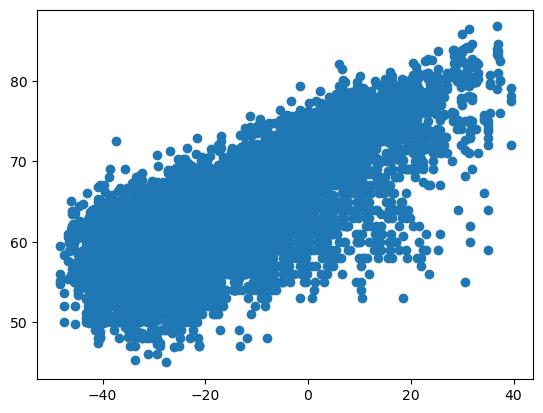

In [34]:
plt.scatter(final_df['PVI'], final_df['happening'])

In [35]:
x_names = ['PVI', 'Crop Damage Per Capita', 'Property Damage Per Capita', 'Injuries Per Capita', 'Fatalities Per Capita']

PVI


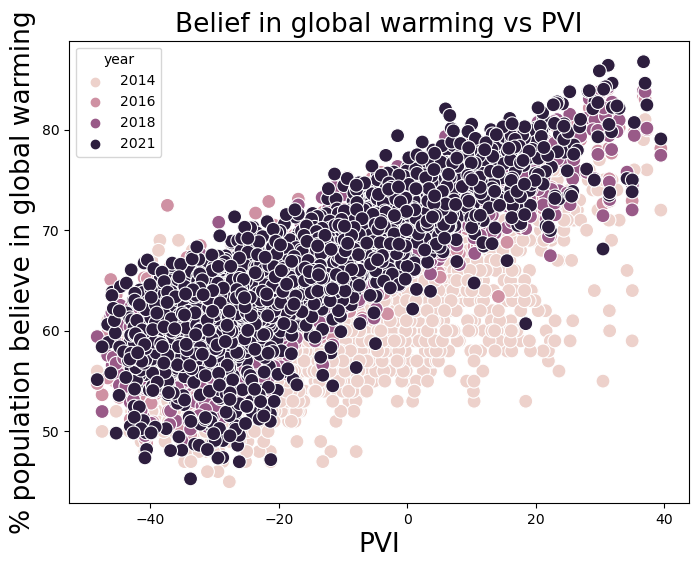

CropDmgPerCapita(ADJ 2020)


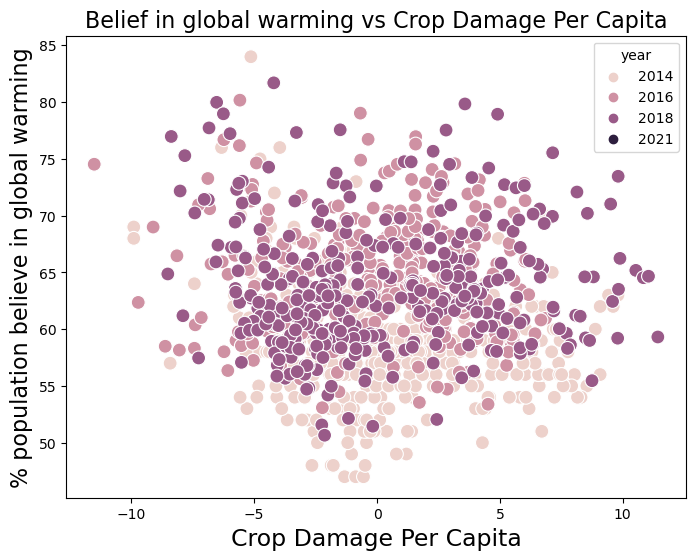

PropertyDmgPerCapita(ADJ 2020)


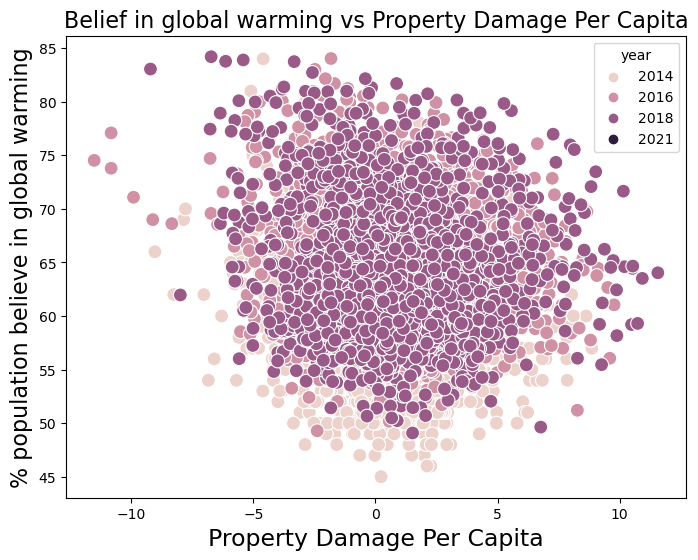

InjuriesPerCapita


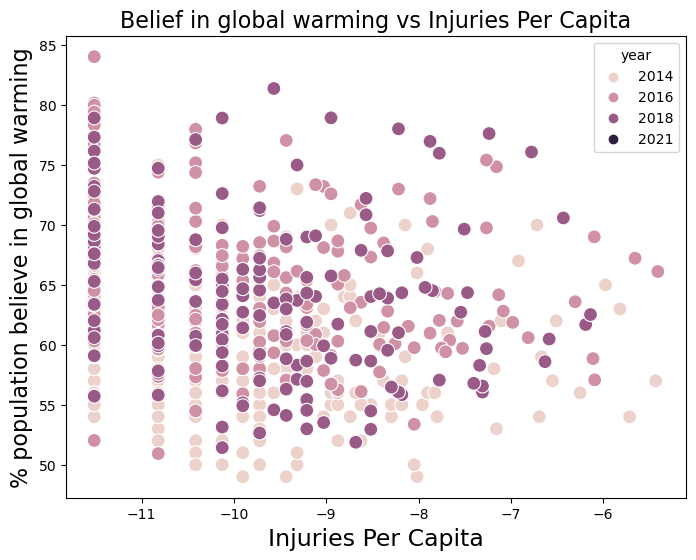

FatalitiesPerCapita


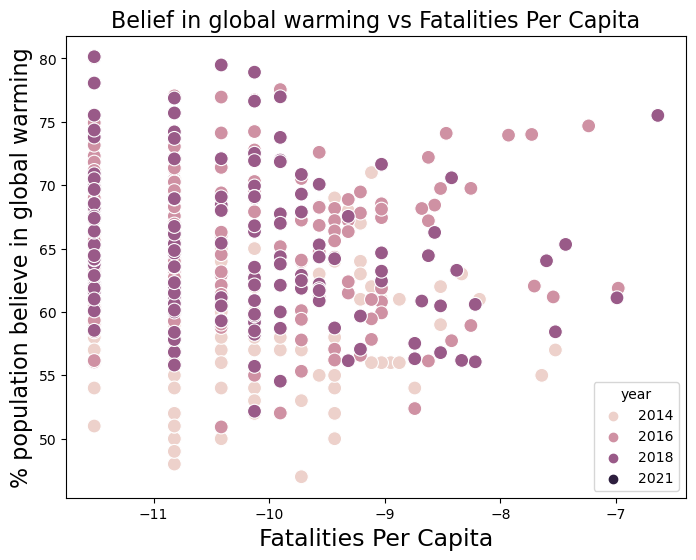

In [41]:
x_names = ['PVI', 'Crop Damage Per Capita', 'Property Damage Per Capita', 'Injuries Per Capita', 'Fatalities Per Capita']

for c, c_name in zip(list(final_df.columns[13:]), x_names):
    print(c)
    plt.figure(figsize = (8, 6))
    
    if c != 'PVI':
        temp_df = final_df[[c, 'happening', 'year']]
        temp_df= temp_df[temp_df[c] != 0]
        temp_df[c] = np.log(temp_df[c])
        sns.scatterplot(x = c, y = 'happening', data=temp_df, hue='year', s=100)
        
        plt.xlabel(c_name,fontsize = 17)
        plt.ylabel('% population believe in global warming',fontsize = 16)
        plt.title('Belief in global warming vs '+ str(c_name),fontsize = 16)
        plt.show()
    
    else: 
        sns.scatterplot(x = 'PVI', y = 'happening', data=final_df, hue='year', s=100)
        plt.xlabel(c,fontsize = 19)
        plt.ylabel('% population believe in global warming',fontsize = 19)
        plt.title('Belief in global warming vs '+ str(c_name),fontsize = 19)
        plt.show()

Text(0.5, 0, 'PVI')

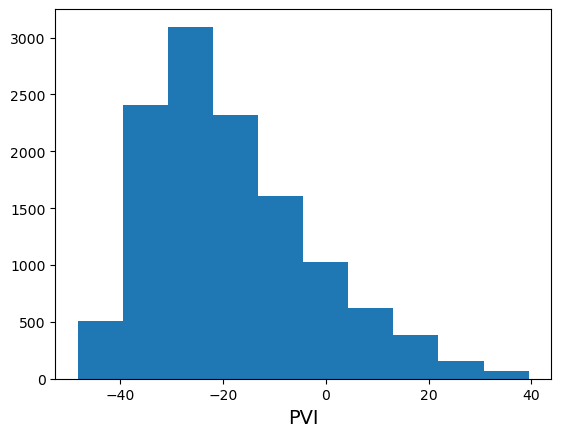

In [36]:
plt.hist(final_df['PVI'])
plt.xlabel('PVI',fontsize=14)

Text(0.5, 0, '% population believes climate change is happening')

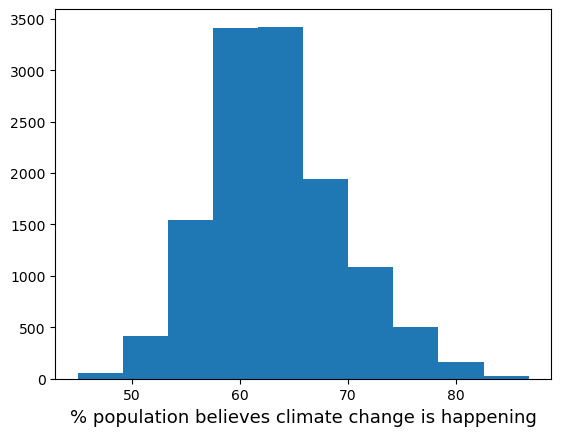

In [37]:
plt.hist(final_df['happening'])
plt.xlabel('% population believes climate change is happening',fontsize=13)

Year: 2014


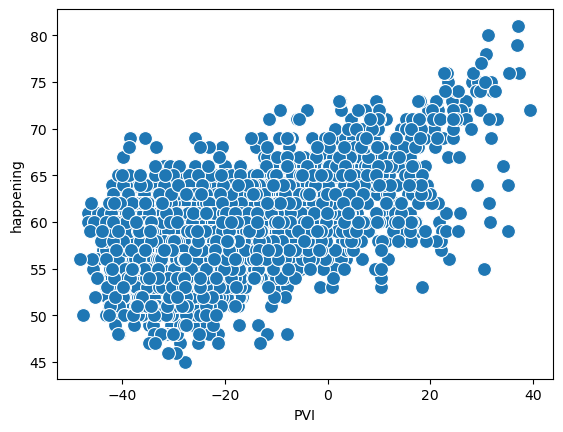

Year: 2016


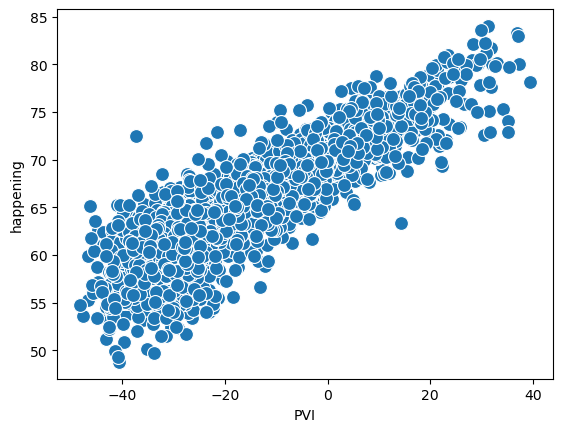

Year: 2018


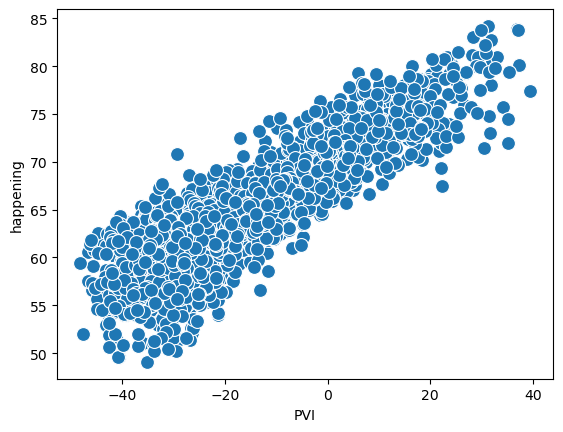

Year: 2021


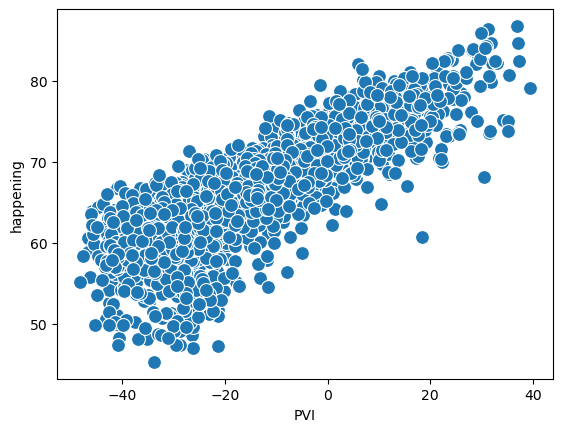

In [38]:
# merged_14 = merged[merged.year == '2014']
years = np.unique(final_df.year).tolist()
for yr in years:
    df = final_df[final_df.year == yr]
    print("Year:", yr)
    sns.scatterplot(x = 'PVI', y = 'happening', data=df,s=100)
    plt.show()

### Simple linear regression

In [44]:
def linear_regression_plot (x, y, x_name, y_name, data_name, xlabel, ylabel):

    x2 = sm.add_constant(x)
    X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size = 0.3, random_state = 0)

    # Fit the simple linear regression
    sm_model = sm.OLS(y_train, X_train, missing='drop')
    results = sm_model.fit()

    # Make predictions using the linear regression
    y_pred_x2 = results.predict(x2)
    y_pred = results.predict(X_test)
    
    #extract p-value for specific predictor variable name
    p_val_x = results.pvalues.loc[x_name]
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
    if p_val_x < 0.05:
        sig_ind = x_name
        yes = 'yes'
        no = 'NA'
        
        print(y_name+' vs '+x_name)
        # Plot 
        xtest = np.array(X_test.iloc[:,-1:])
        plt.figure(figsize=(15, 8), dpi=80)
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue='year', s=100)
        p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)#,borderaxespad = 0., ncol = 1)
        plt.plot(x, y_pred_x2, color='blue', linewidth=3)
        plt.plot(xtest, y_pred, color='red', linewidth=5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)

        plt.show()
        
        
        print(results.summary())
        print('==============================================')
        
        
        #checking assumptions
        #plot residuals
        print()
        print("Residuals vs Fitted Values-- looking for heteroskedascity")
        resids = results.resid
#         y_pred = results.predict(X_train)
        fitted_vals = results.fittedvalues
        plt.scatter(fitted_vals, resids, color='black', alpha = 0.25)
#         plt.scatter(y_pred, resids,  color='black', alpha = 0.25)
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.show()
        
        #qq plot for normality of residuals
        print('Residuals-- checking normality')
        sm.qqplot(resids, line='s') #get p values
        plt.show()
        
        if shapiro(resids)[1] < 0.05:
            print('Residuals are not normal')
            
            resids_not_normal = x_name
        
        print('=========================================================================================')
        
    
    else:
        not_sig_ind = x_name
    
    print('=========================================================================================')
    
    return sig_ind, not_sig_ind, resids_not_normal

In [40]:
for c in list(final_df.columns[14:]):
    final_df[c] = np.log(final_df[c])

C:\Users\maham\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
indicators

['PVI',
 'CropDmgPerCapita(ADJ 2020)',
 'PropertyDmgPerCapita(ADJ 2020)',
 'InjuriesPerCapita',
 'FatalitiesPerCapita']

C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3452277599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)


happening vs PVI


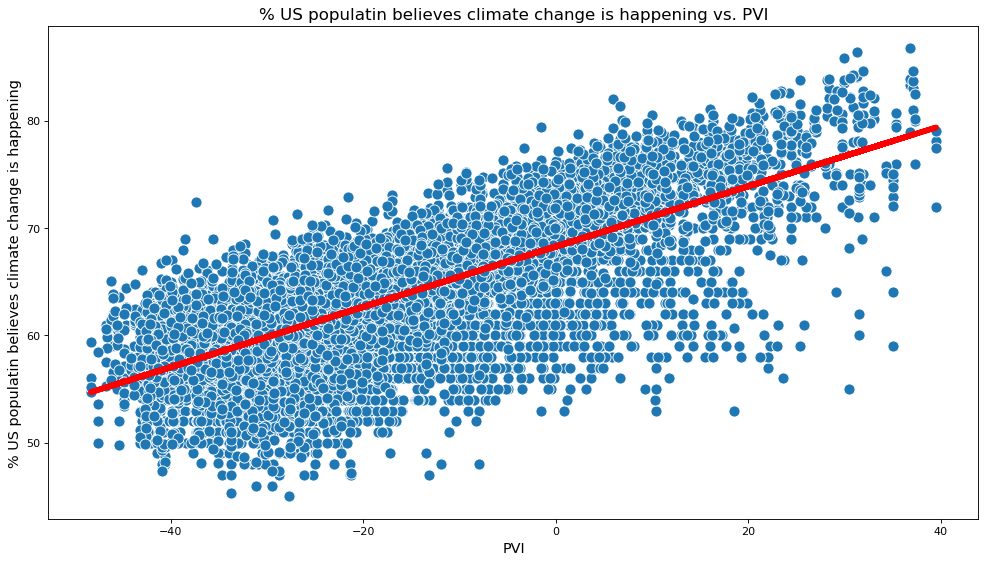

                            OLS Regression Results                            
Dep. Variable:              happening   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:27:25   Log-Likelihood:                -24126.
No. Observations:                8547   AIC:                         4.826e+04
Df Residuals:                    8545   BIC:                         4.827e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.2808      0.067   1018.502      0.0

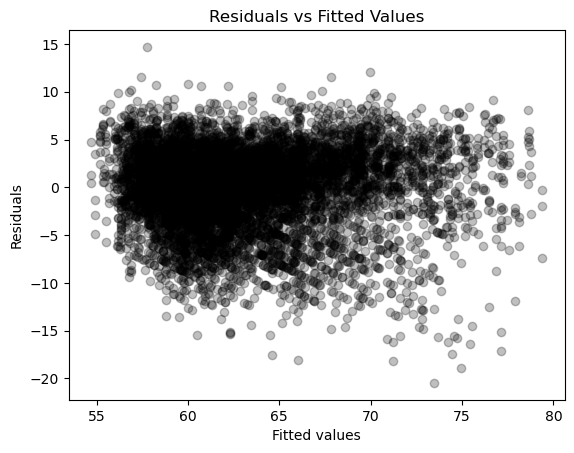

Residuals-- checking normality


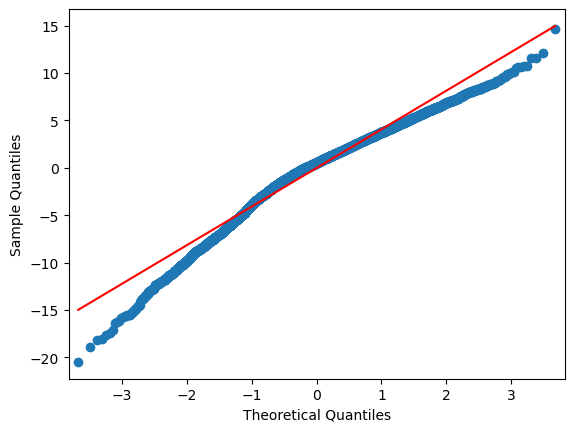

Residuals are not normal
Significant regression for:  ['PVI', [], [], [], []]

Not significant regression for:  [[], 'CropDmgPerCapita(ADJ 2020)', 'PropertyDmgPerCapita(ADJ 2020)', 'InjuriesPerCapita', 'FatalitiesPerCapita']

Residuals are not normal when (% pop belief in climate change) plotted againstFatalitiesPerCapita ['PVI', [], [], [], []]


C:\Users\maham\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3452277599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)
C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3452277599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)
C:\Users\maham\AppD

In [198]:
indicators = final_df.columns.tolist()[13:] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = final_df[['year', 'happening',i]]
    temp_df[i] = temp_df[i].astype(float)
    
    x_col = temp_df[i]
    y_col = temp_df['happening']
    

    sig, not_sig, resids_not_normal = linear_regression_plot(x_col, y_col, i, 'happening', temp_df, i,'% US populatin believes climate change is happening')
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when (% pop belief in climate change) plotted against'+str(i), resid_not_norm_y)

## LR for PVI by year

In [46]:
def linear_regression_plot (x, y, x_name, y_name, data_name, xlabel, ylabel):

    x2 = sm.add_constant(x)
    X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size = 0.3, random_state = 0)

    # Fit the simple linear regression
    sm_model = sm.OLS(y_train, X_train, missing='drop')
    results = sm_model.fit()

    # Make predictions using the linear regression
    y_pred_x2 = results.predict(x2)
    y_pred = results.predict(X_test)
    
    #extract p-value for specific predictor variable name
    p_val_x = results.pvalues.loc[x_name]
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
    if p_val_x < 0.05:
        sig_ind = xlabel
        yes = 'yes'
        no = 'NA'
        
        print(y_name+' vs '+x_name)
        # Plot 
        xtest = np.array(X_test.iloc[:,-1:])
        plt.figure(figsize=(15, 8), dpi=80)
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, s=100)
        plt.plot(x, y_pred_x2, color='blue', linewidth=3)
        plt.plot(xtest, y_pred, color='red', linewidth=5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)

        plt.show()
        
        
        print(results.summary())
        print('==============================================')
        
        
        #checking assumptions
        #plot residuals
        print()
        print("Residuals vs Fitted Values-- looking for heteroskedascity")
        resids = results.resid
#         y_pred = results.predict(X_train)
        fitted_vals = results.fittedvalues
        plt.scatter(fitted_vals, resids, color='black', alpha = 0.25)
#         plt.scatter(y_pred, resids,  color='black', alpha = 0.25)
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.show()
        
        #qq plot for normality of residuals
        print('Residuals-- checking normality')
        sm.qqplot(resids, line='s') #get p values
        plt.show()
        
        if shapiro(resids)[1] < 0.05:
            print('Residuals are not normal')
            
            resids_not_normal = xlabel
        
        print('=========================================================================================')
        
    
    else:
        not_sig_ind = xlabel
    
    print('=========================================================================================')
    
    return sig_ind, not_sig_ind, resids_not_normal

happening vs PVI


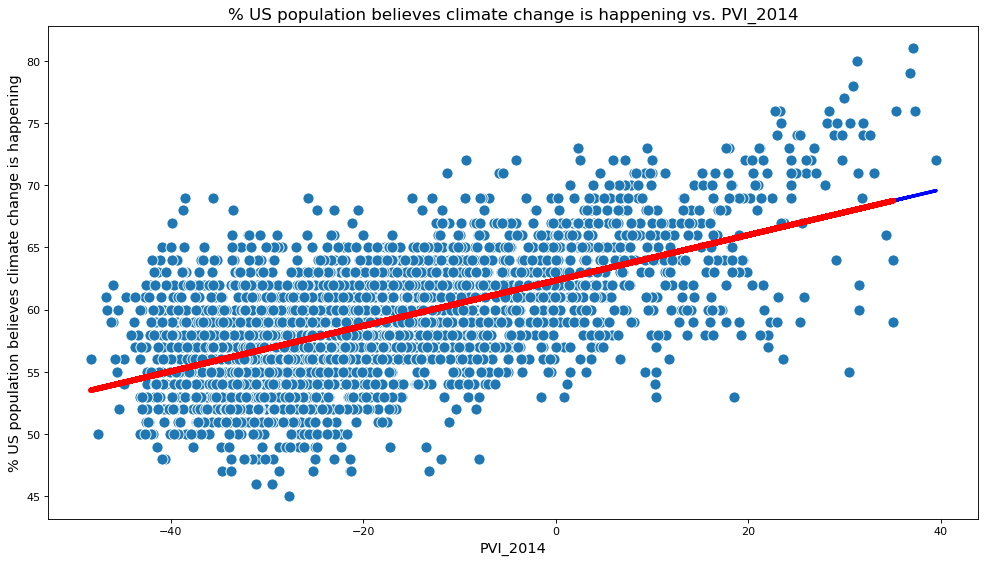

                            OLS Regression Results                            
Dep. Variable:              happening   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     1220.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          9.61e-212
Time:                        23:33:42   Log-Likelihood:                -5893.8
No. Observations:                2132   AIC:                         1.179e+04
Df Residuals:                    2130   BIC:                         1.180e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3527      0.127    490.046      0.0

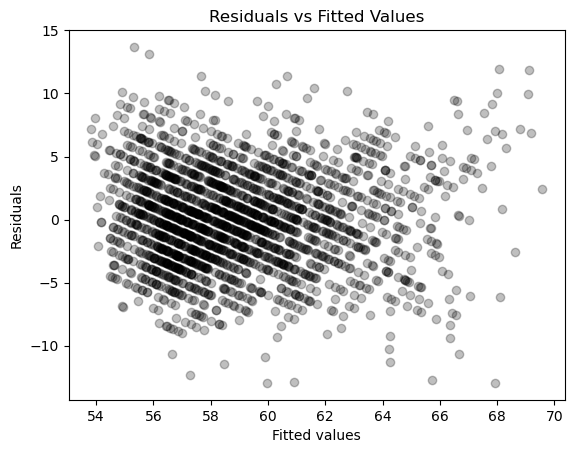

Residuals-- checking normality


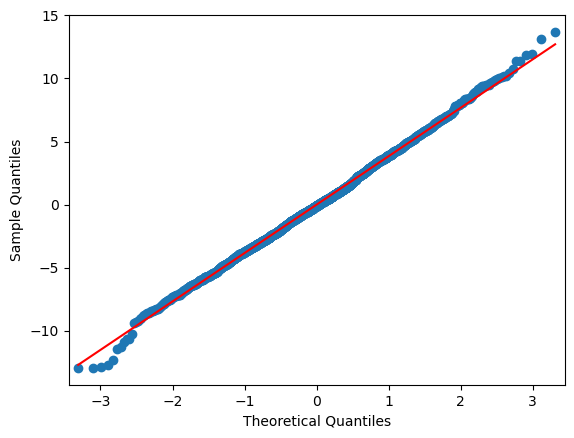

happening vs PVI


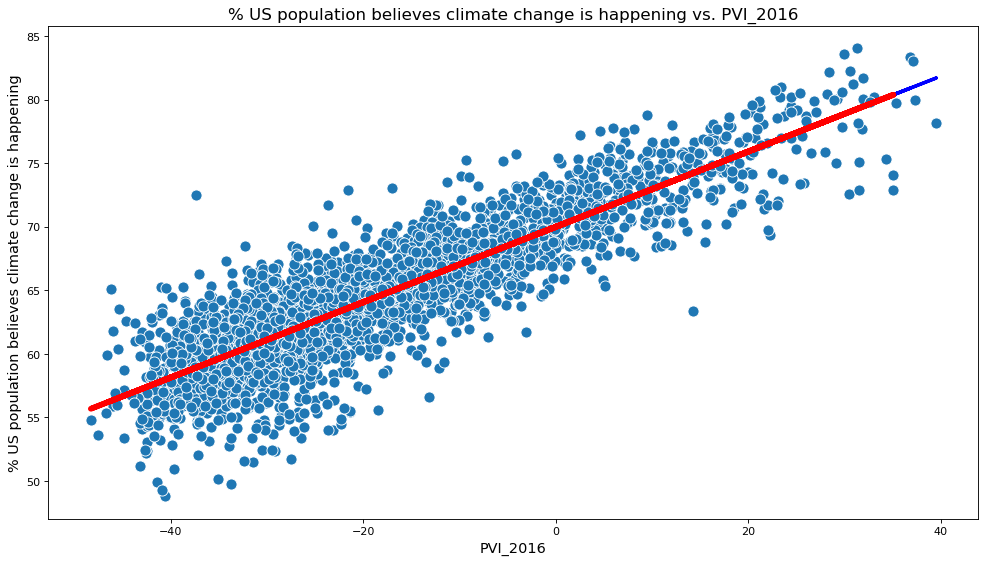

                            OLS Regression Results                            
Dep. Variable:              happening   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     7154.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:33:43   Log-Likelihood:                -5012.3
No. Observations:                2125   AIC:                         1.003e+04
Df Residuals:                    2123   BIC:                         1.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.9949      0.085    819.449      0.0

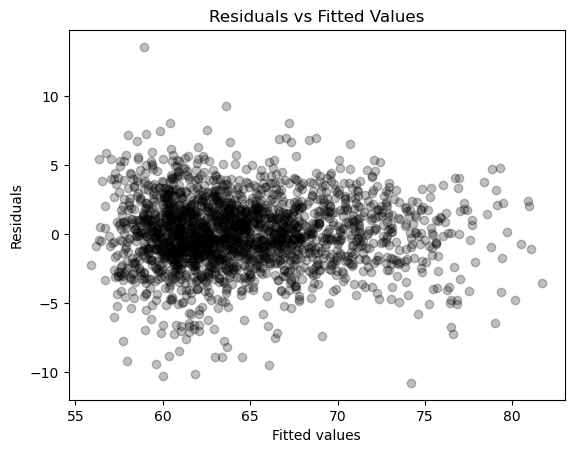

Residuals-- checking normality


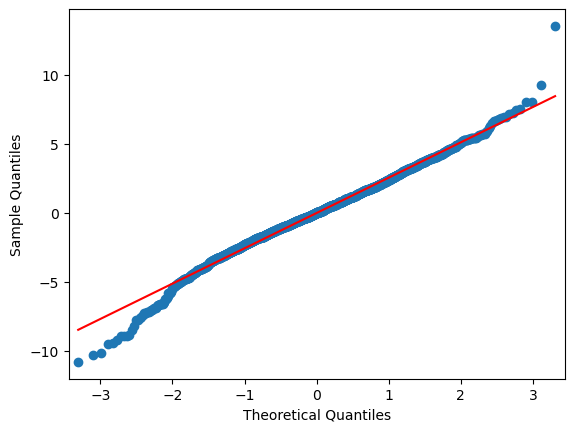

Residuals are not normal
happening vs PVI


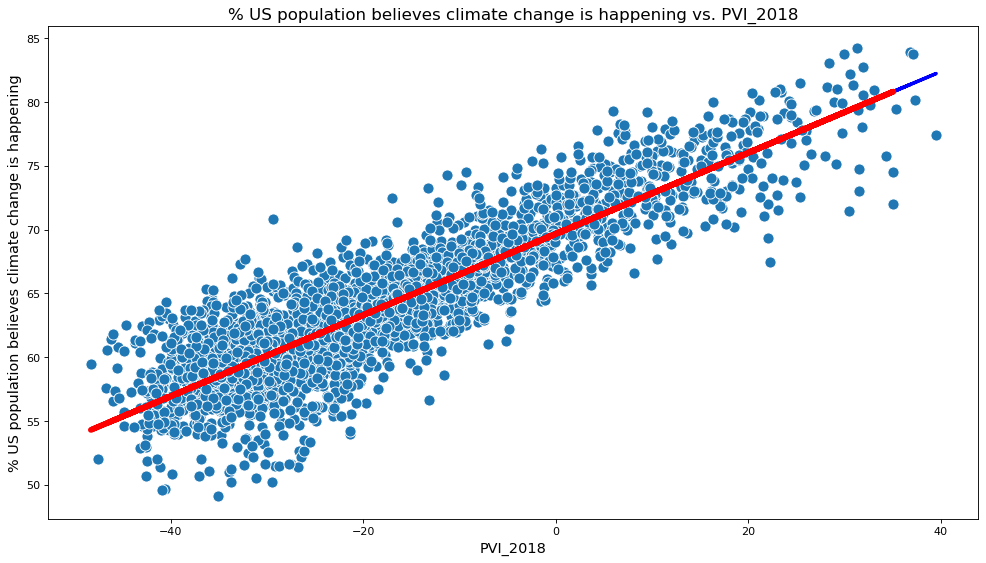

                            OLS Regression Results                            
Dep. Variable:              happening   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     7532.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:33:44   Log-Likelihood:                -5108.5
No. Observations:                2125   AIC:                         1.022e+04
Df Residuals:                    2123   BIC:                         1.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.6618      0.089    779.436      0.0

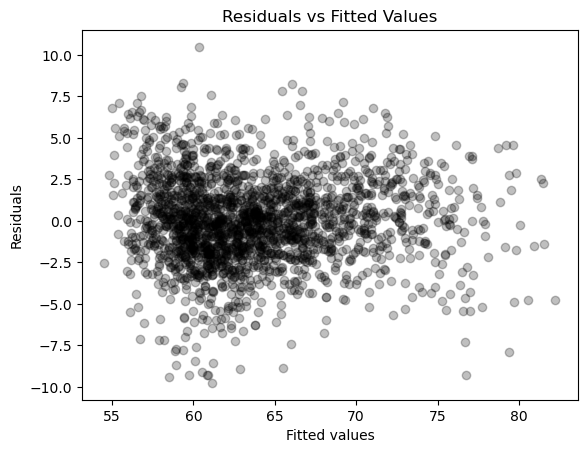

Residuals-- checking normality


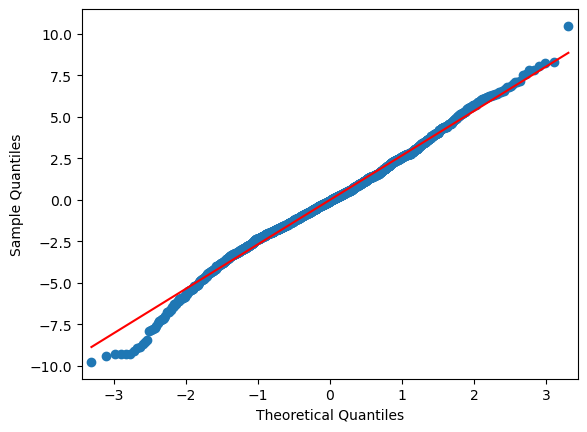

Residuals are not normal
happening vs PVI


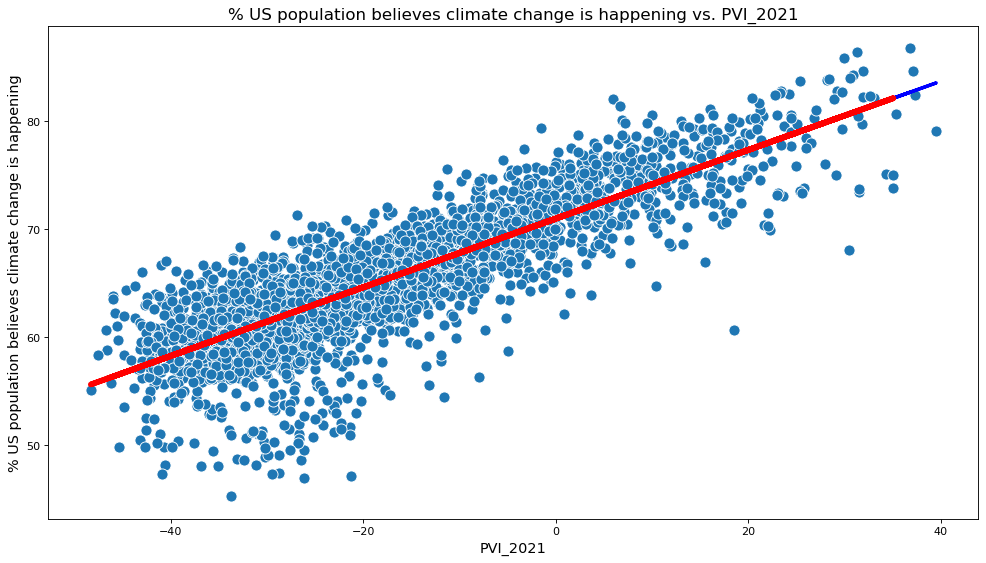

                            OLS Regression Results                            
Dep. Variable:              happening   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     4899.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:33:45   Log-Likelihood:                -5563.2
No. Observations:                2125   AIC:                         1.113e+04
Df Residuals:                    2123   BIC:                         1.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.9961      0.111    641.349      0.0

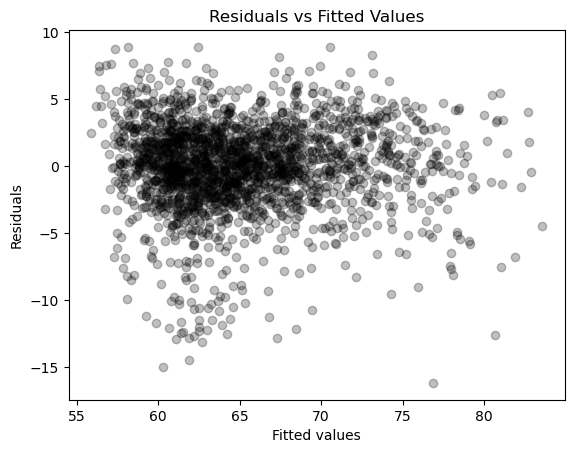

Residuals-- checking normality


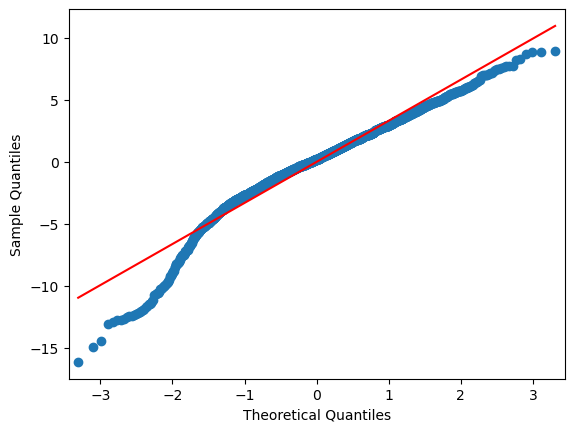

Residuals are not normal
Significant regression for:  ['PVI_2014', 'PVI_2016', 'PVI_2018', 'PVI_2021']

Not significant regression for:  [[], [], [], []]


Residuals are not normal when (% pop belief in climate change) plotted against [[], 'PVI_2016', 'PVI_2018', 'PVI_2021']


In [47]:
significant = []
not_significant = []
resid_not_norm_y = []

years = list(final_df.year.unique())
for y in years:
    temp_df = final_df[final_df.year == y]
    temp_df = temp_df[['happening','PVI']]
#     temp_df[i] = temp_df[i].astype(float)
    
    x_col = temp_df['PVI']
    y_col = temp_df['happening']
    
    sig, not_sig, resids_not_normal = linear_regression_plot(x_col, y_col, 'PVI', 'happening', temp_df, 'PVI_'+str(y),'% US population believes climate change is happening')
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)


print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print()
print('Residuals are not normal when (% pop belief in climate change) plotted against', resid_not_norm_y)

### residuals only normal for simple linear regression at PVI_2014

In [192]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
#     print(mse.shape)
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
#     cov = model.cov_params()
#     print(cov.shape)

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

def LR_cv_with_CI(x, y, x_name, y_name, data_name, xlabel, ylabel, color_name):

    df = data_name[[x_name,y_name]]
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)
        
        X_train = df_train[[x_name]]
        X_val = df_val[[x_name]]
    
        # Calculate the MSE for each fold
        MSE_array = []
        
        
        # Fit the simple linear regression
        y_train = df_train[y_name]
        x_train = sm.add_constant(X_train)
        sm_model = sm.OLS(y_train, X_train, missing='drop')
        results = sm_model.fit()

        # Make predictions using the linear regression
#         x_val = sm.add_constant(X_val)
        y_pred = results.predict(pd.DataFrame(X_val))

        y_true = df_val[y_name]
        MSE = np.square(np.subtract(y_true,y_pred)).mean()
        MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_min = min(mses.mses_ave)
    
    #confidence interval

    df = df.dropna(subset=[y_name])
    X = df[[x_name]]
    y = df[[y_name]]
    X = sm.add_constant(X)
#     print(X)
#     print(x)
#     print(x['PVI'])
    mod = sm.OLS(y, X, missing='drop')
    results = mod.fit()
    
    
    if results.pvalues[1] < 0.05:
        
        sig_ind = xlabel
        yes = 'yes'
        no = 'NA'
        
        y_pred_all = results.predict(pd.DataFrame(X))

        X_reshape = np.array(X['PVI']).reshape(-1, 1)
        y_reshape = np.array(y).reshape(-1, 1)
        y_pred_all_reshape = np.array(y_pred_all).reshape(-1, 1)

        conf_int = confidence_interval(X_reshape, y_reshape, y_pred_all_reshape)
        
        print(y_name+' vs '+x_name)

        plt.figure(figsize=(15, 8), dpi=80)
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name,s=100, alpha=0.5)
            

        data_name = data_name.dropna(subset=[y_name])
        plt.plot(data_name[x_name], y_pred_all, color_name)
        plt.fill_between(data_name[x_name], y_pred_all-conf_int, y_pred_all+conf_int, facecolor = color_name, alpha = 0.5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)
#         plt.legend(loc='upper left')
        plt.show()
        
        print('Average validation MSE over 5 folds: ',MSE_ave_min)
        print()
        
        print(results.summary())
        print('======================================================================================')
        print()
        

    else:
        not_sig_ind = []
        not_sig_ind = xlabel
    
    print('=========================================================================================')
    print()
    
    

    return sig_ind, not_sig_ind

happening vs PVI


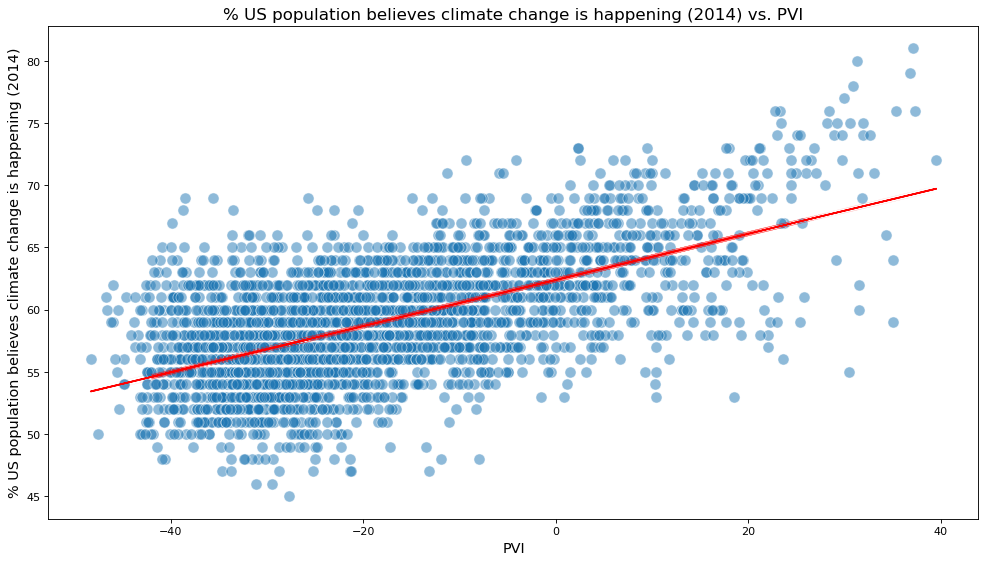

Average validation MSE over 5 folds:  1687.8781831590204

                            OLS Regression Results                            
Dep. Variable:              happening   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     1827.
Date:                Wed, 28 Dec 2022   Prob (F-statistic):          2.93e-313
Time:                        00:37:49   Log-Likelihood:                -8425.8
No. Observations:                3053   AIC:                         1.686e+04
Df Residuals:                    3051   BIC:                         1.687e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

UnboundLocalError: local variable 'not_sig_ind' referenced before assignment

In [193]:
significant = []
not_significant = []

temp_df = final_df[final_df.year == 2014]
temp_df = temp_df[['year','happening','PVI']]
temp_df = temp_df.dropna(axis=0)

x_col = temp_df['PVI']
y_col = temp_df['happening']

sig, not_sig = LR_cv_with_CI(x_col, y_col, 'PVI', 'happening', temp_df, 'PVI','% US population believes climate change is happening ('+str(2014)+')','r')
significant.append(sig)
not_significant.append(not_sig)


### Multiple Linear Regression

- didn't make sense to do as other regressions were not significant

## Quantile Regressions for all

B/c residuals were not normal

In [46]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
#     print(mse.shape)
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
#     cov = model.cov_params()
#     print(cov.shape)

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

In [47]:
def QR_cv_with_CI(x, y, x_name, y_name, data_name, xlabel, ylabel, quantile):

    df = data_name[[x_name,y_name]]
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)
        
        X_train = df_train[[x_name]]
        X_val = df_val[[x_name]]
    
        # Calculate the MSE for each fold
        MSE_array = []
        
        # Fit the quantile regression
        equation = y_name+' ~ '+x_name
        mod = smf.quantreg(equation, df_train)
        results = mod.fit(q=quantile)
        y_pred = results.predict(pd.DataFrame(X_val))

        y_true = df_val[y_name]
        MSE = np.square(np.subtract(y_true,y_pred)).mean()
        MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_min = min(mses.mses_ave)
    
    #confidence interval

    df = df.dropna(subset=[y_name])
    X = df[[x_name]]
    y = df[[y_name]]
    equation = y_name+' ~ '+x_name
    mod = smf.quantreg(equation, df)
    results = mod.fit(q=quantile)
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
    if results.pvalues[1] < 0.05:
        
        sig_ind = x_name
        yes = 'yes'
        no = 'NA'
        
        y_pred_all = results.predict(pd.DataFrame(X))

        X_reshape = np.array(X).reshape(-1, 1)
        y_reshape = np.array(y).reshape(-1, 1)
        y_pred_all_reshape = np.array(y_pred_all).reshape(-1, 1)

        conf_int = confidence_interval(X_reshape, y_reshape, y_pred_all_reshape)
        
        print(y_name+' vs '+x_name)

        plt.figure(figsize=(15, 8), dpi=80)
#         hue_order = ['High-Income', 'Upper-Middle Income', 'Lower-Middle Income', 'Low-Income']
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'year',s=100, alpha=0.5)
            
#         p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', s=100, alpha=0.5)
        p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)

        data_name = data_name.dropna(subset=[y_name])
        plt.plot(data_name[x_name], y_pred_all, 'm')
        plt.fill_between(data_name[x_name], y_pred_all-conf_int, y_pred_all+conf_int, facecolor = 'm', alpha = 0.5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)
        plt.show()
        
        print('Average validation MSE over 5 folds: ',MSE_ave_min)
        print()
        
        print(results.summary())
        print('======================================================================================')
        print()

    else:
        not_sig_ind = x_name
    
    print('=========================================================================================')
    print()

    return sig_ind, not_sig_ind

In [50]:
final_df = final_df.rename(columns={'CropDmgPerCapita(ADJ 2020)': 'crop_dmg_capita'})
final_df = final_df.rename(columns={'PropertyDmgPerCapita(ADJ 2020)': 'property_dmg_capita'})

C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3906554844.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)


happening vs PVI


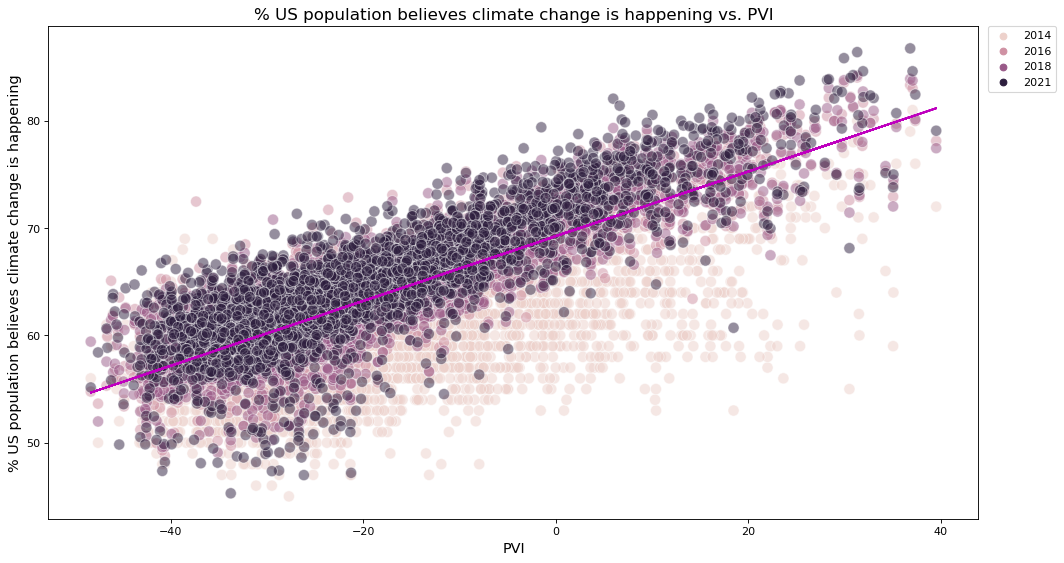

Average validation MSE over 5 folds:  16.969148636632287

                         QuantReg Regression Results                          
Dep. Variable:              happening   Pseudo R-squared:               0.3486
Model:                       QuantReg   Bandwidth:                      0.7509
Method:                 Least Squares   Sparsity:                        8.032
Date:                Tue, 27 Dec 2022   No. Observations:                12212
Time:                        23:34:15   Df Residuals:                    12210
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.2457      0.055   1248.900      0.000      69.137      69.354
PVI            0.3019      0.002    132.409      0.000       0.297       0.306





C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3906554844.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)
C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3906554844.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)


C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3906554844.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)
C:\Users\maham\AppData\Local\Temp\ipykernel_19000\3906554844.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[i] = temp_df[i].astype(float)



Significant regression for:  ['PVI', [], [], [], []]

Not significant regression for:  [[], 'crop_dmg_capita', 'property_dmg_capita', 'InjuriesPerCapita', 'FatalitiesPerCapita']



In [51]:
# warnings.filterwarnings("ignore")
indicators = final_df.columns.tolist()[13:]
significant = []
not_significant = []

for i in indicators:
    temp_df = final_df[['year', 'happening',i]]
    temp_df[i] = temp_df[i].astype(float)
    
    x_col = temp_df[i]
    y_col = temp_df['happening']


    sig, not_sig = QR_cv_with_CI(x_col, y_col, i, 'happening', temp_df, i,'% US population believes climate change is happening', 0.5)
    significant.append(sig)
    not_significant.append(not_sig)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
# warnings.filterwarnings("default")

## quantile regression by year

In [52]:
def QR_cv_with_CI(x, y, x_name, y_name, data_name, xlabel, ylabel, quantile, color_name):

    df = data_name[[x_name,y_name]]
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)
        
        X_train = df_train[[x_name]]
        X_val = df_val[[x_name]]
    
        # Calculate the MSE for each fold
        MSE_array = []
        
        # Fit the quantile regression
        equation = y_name+' ~ '+x_name
        mod = smf.quantreg(equation, df_train)
        results = mod.fit(q=quantile)
        y_pred = results.predict(pd.DataFrame(X_val))

        y_true = df_val[y_name]
        MSE = np.square(np.subtract(y_true,y_pred)).mean()
        MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_min = min(mses.mses_ave)
    
    #confidence interval

    df = df.dropna(subset=[y_name])
    X = df[[x_name]]
    y = df[[y_name]]
    equation = y_name+' ~ '+x_name
    mod = smf.quantreg(equation, df)
    results = mod.fit(q=quantile)
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
    if results.pvalues[1] < 0.05:
        
        sig_ind = xlabel
        yes = 'yes'
        no = 'NA'
        
        y_pred_all = results.predict(pd.DataFrame(X))

        X_reshape = np.array(X).reshape(-1, 1)
        y_reshape = np.array(y).reshape(-1, 1)
        y_pred_all_reshape = np.array(y_pred_all).reshape(-1, 1)

        conf_int = confidence_interval(X_reshape, y_reshape, y_pred_all_reshape)
        
        print(y_name+' vs '+x_name)

#         plt.figure(figsize=(15, 8), dpi=80)
#         p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name,s=100, alpha=0.5)
            

        data_name = data_name.dropna(subset=[y_name])
        plt.plot(data_name[x_name], y_pred_all, color_name, label=temp_df['year'].iloc[0])
        plt.fill_between(data_name[x_name], y_pred_all-conf_int, y_pred_all+conf_int, facecolor = color_name, alpha = 0.5)
        plt.xlabel(xlabel, fontsize=18)
        plt.ylabel(ylabel, fontsize=18)
        plt.title(ylabel +' vs. '+xlabel, fontsize=19)
        plt.legend(loc='upper left')
#         plt.show()
        
        print('Average validation MSE over 5 folds: ',MSE_ave_min)
        print()
        
        print(results.summary())
        print('======================================================================================')
        print()
        
        x_data = data_name[x_name]
        y_preds_all = y_pred_all
        conf_int_all = conf_int
        

    else:
        not_sig_ind = xlabel
    
    print('=========================================================================================')
    print()
    
    

    return sig_ind, not_sig_ind, x_data, y_preds_all, conf_int_all

happening vs PVI
Average validation MSE over 5 folds:  14.639146642107132

                         QuantReg Regression Results                          
Dep. Variable:              happening   Pseudo R-squared:               0.1936
Model:                       QuantReg   Bandwidth:                       1.293
Method:                 Least Squares   Sparsity:                        8.799
Date:                Mon, 02 Jan 2023   No. Observations:                 3053
Time:                        22:38:24   Df Residuals:                     3051
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.4192      0.121    513.868      0.000      62.181      62.657
PVI            0.1916      0.005     38.367      0.000       0.182       0.201


happening vs PVI
Average validation MSE over 5 folds: 

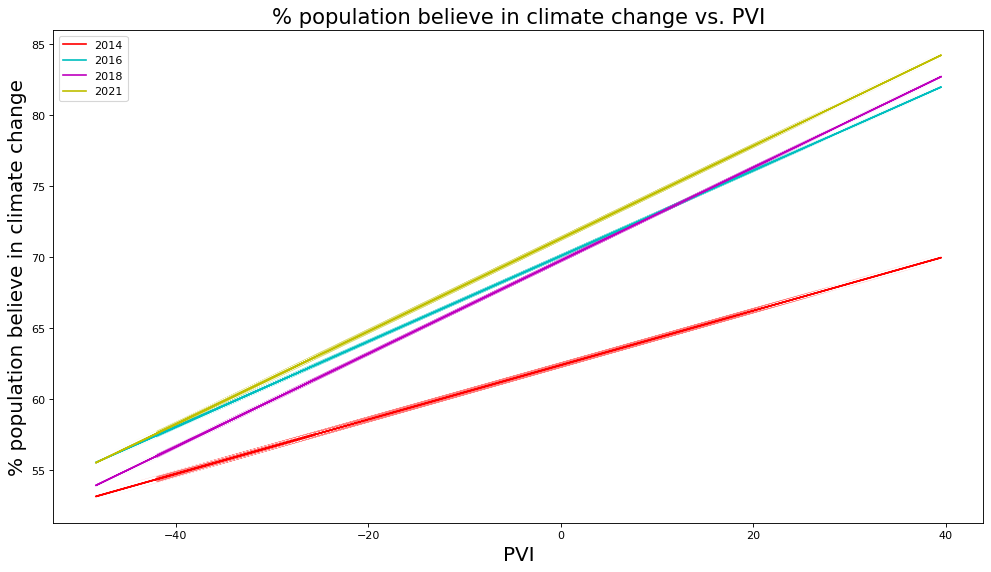

In [53]:
# df_QR = pd.DataFrame(columns = ["PVI_data", "y_preds_QR", "conf_int_QR","year"])
plt.figure(figsize=(15, 8), dpi=80)
no_nan = final_df[['year','happening','PVI']]
no_nan = no_nan.dropna(axis=0)

significant = []
not_significant = []

years = list(no_nan.year.unique())
color_list = ['r','c','m','y']
for y,c in zip(years,color_list):
    x_data_ls = []
    y_preds_all_ls = []
    conf_int_all_ls = []
    year_ls = []
    
    temp_df = no_nan[no_nan.year == y]
    temp_df = temp_df[['year','happening','PVI']]
    
    x_col = temp_df['PVI']
    y_col = temp_df['happening']
    
    sig, not_sig, x_data, y_preds_all, conf_int_all = QR_cv_with_CI(x_col, y_col, 'PVI', 'happening', temp_df, 'PVI','% population believe in climate change', 0.5, c)
    significant.append(sig)
    not_significant.append(not_sig)
    x_data_ls.append(x_data)
    y_preds_all_ls.append(y_preds_all)
    conf_int_all_ls.append(conf_int_all)
    year = y
    
    x_data_ls = list(np.transpose(x_data_ls))
    y_preds_all_ls = list(np.transpose(y_preds_all_ls))
    conf_int_all_ls = list(np.transpose(conf_int_all_ls))
    
    if year == 2014:
        for i in range(len(x_data_ls)):
            year_ls.append(year)
        QR_data = pd.DataFrame(list(zip(x_data_ls, y_preds_all_ls, conf_int_all_ls, year_ls)),
               columns =["PVI_data", "y_preds_QR", "conf_int_QR","year"])
    else:
        for i in range(len(x_data_ls)):
            year_ls.append(year)
        other_data =  pd.DataFrame(list(zip(x_data_ls, y_preds_all_ls, conf_int_all_ls, year_ls)),
               columns =["PVI_data", "y_preds_QR", "conf_int_QR","year"])
        
        QR_data = pd.concat([QR_data, other_data], ignore_index=True, axis=0)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()